# Do the following to have the graphical features available on Colab

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (46.1.3)


## **Necessary Imports**

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
# if is_python: from IPython import display

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1033'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1033'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

# **Utility Functions for displaying video**

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

This method is the most suitable and easy for solving CartPole problem.
You can further increase the complexity of this model.


There are 2 fully connected layers which are given the input, a matrix with the following dimensions:
(height_of_image x width_of_image x num_of_channels (i.e. 3, RBG)

It will be safe to mention here that the input to the network is the difference between the next state and the current state. This is done so that the network takes into consideration the velocity of the cart.

In [0]:
class DQN(nn.Module):
  def __init__(self,img_height,img_width):
    super().__init__()

    self.fc1 = nn.Linear(in_features=img_height*img_width*3,out_features=24)
    self.fc2 = nn.Linear(in_features=24,out_features=32)
    self.out = nn.Linear(in_features=32, out_features=2)

  def forward(self,t):
    t = t.flatten(start_dim=1)
    t = F.relu(self.fc1(t))
    t = F.relu(self.fc2(t))
    t = self.out(t)
    return t



We have created a namedtuple which will be stored in the ReplayMemory.
It is convinient to use a single variable to access all the necessary features of the network.

In [0]:
Experience = namedtuple('Experience',('state','action','next_state','reward'))

We use a new data structure, called ReplayMemory so that the network doesn't forget the previous states which are passed to it.

This is so because if the network is fed in a continuous frame followed by another frame, it tends to remember the sequence and not actually learn how to carry out the task.

With Replay Memory, we store the states which are to be fed to the network and sample from it randomly to break the patterned learning form.

This datastructure has a capacity which can be set by the user depending on their preference and is like a Circular List. You keep appending to the list till the capacity has been reached or you replace the elements.

In [0]:
class ReplayMemory():
  def __init__(self,capacity):
    self.capacity = capacity
    self.memory = []
    self.push_count = 0

  def push(self,experience):
    if len(self.memory)<self.capacity:
      self.memory.append(experience)
    else:
      self.memory[self.push_count%self.capacity] = experience
    self.push_count+=1

  def sample(self,batch_size):
    return random.sample(self.memory, batch_size)

  def can_provide_sample(self,batch_size):
    return len(self.memory)>=batch_size

This strategy is used so that the network explores and exploits at the same time. In order to maintain this balance and to improve the performance of the algorithm, we initially start to explore as we don't have any strategy of selecting the optimal choice. Then as time progresses we start to decay the exploration rate and as a result, the strategy switches to exploit the space with the best possible actions for the foreseeable future.

In [0]:
class EpsilonGreedyStrategy():
  def __init__(self,start,end,decay):
    self.start = start
    self.end = end
    self.decay = decay

  def get_exploration_rate(self,current_step):
    return self.end+(self.start-self.end)*math.exp(-1*current_step*self.decay)

This is the agent class which will be actually controlling the Cart to balance the pole with EpsilonGreedy Strategy.

It generates a random number to check with the epsilon rate. If it is higher it explores, if it is lower, it exploits.

In [0]:
class Agent():
  def __init__(self,strategy,num_actions,device):
    self.current_step = 0
    self.strategy = strategy
    self.num_actions = num_actions
    self.device = device

  def select_action(self,state,policy_net):
    rate = strategy.get_exploration_rate(self.current_step)
    self.current_step+=1

    if rate>random.random():
      action = random.randrange(self.num_actions)
      return torch.tensor([action]).to(device)
    else:
      with torch.no_grad():
        return policy_net(state).argmax(dim=1).to(device)

This is a class with all the necessary functions to interact with the environment.

Most of the functions are self explainatory. However, let's discuss the preprocessing part.

As the CartPole window comprises of unwanted regions of focus to the network, we reduce the screen size and focus on just the necessary bit by cropping. Later, we normalize the pixel values from [0,1] and make use of torchvision transforms to get PILImage, Resize it and convert it into a Tensor.

Note that for the final state, we return a black screen.

In [0]:
class CartPoleEnvManager():
  def __init__(self,device):
    self.device = device
    self.env = wrap_env(gym.make('CartPole-v0').unwrapped)
    self.env.reset()
    self.current_screen = None
    self.done = False
  
  def reset(self):
    self.env.reset()
    self.current_screen = None
  
  def close(self):
    self.env.close()

  def render(self,mode='human'):
    return self.env.render(mode)

  def num_actions_available(self):
    return self.env.action_space.n

  def take_action(self,action):
    _, reward, self.done, _ = self.env.step(action.item())
    return torch.tensor([reward],device=self.device)

  def just_starting(self):
    return self.current_screen is None

  def get_state(self):
    if self.just_starting() or self.done:
      self.current_screen = self.get_processed_screen()
      black_screen = torch.zeros_like(self.current_screen)
      return black_screen
    else:
      s1 = self.current_screen
      s2 = self.get_processed_screen()
      self.current_screen = s2
      return s2-s1

  def get_screen_height(self):
    screen = self.get_processed_screen()
    return screen.shape[2]

  def get_screen_width(self):
    screen = self.get_processed_screen()
    return screen.shape[3]

  def get_processed_screen(self):
    screen = self.render('rgb_array').transpose((2,0,1))
    screen = self.crop_screen(screen)
    return self.transform_screen_data(screen)

  def crop_screen(self,screen):
    screen_height = screen.shape[1]
    top = int(screen_height*0.4)
    bottom = int(screen_height*0.8)
    screen = screen[:,top:bottom,:]
    return screen

  def transform_screen_data(self,screen):
    screen = np.ascontiguousarray(screen,dtype=np.float32)/255
    screen = torch.from_numpy(screen)

    resize = T.Compose([T.ToPILImage(),T.Resize((40,90)),T.ToTensor()])

    return resize(screen).unsqueeze(0).to(self.device)

These are 2 utility functions to plot the episode duration and the avg value of the episode duration over a given period of time. Episode duration will be for how long the simulation went for, that is for how long the cart could balance the pole. In this case, its 100 so for the first 100 episodes, the average episode duration will be 0.

In [0]:
def plot(values,moving_avg_period):
  plt.figure(2)
  plt.clf()
  plt.title('Training..')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(values)
  moving_avg = get_moving_average(moving_avg_period,values)
  plt.plot(moving_avg)
  plt.pause(0.001)
  print("Episode",len(values),"\n",moving_avg_period,"episode moving avg:",moving_avg[-1])
  if is_ipython: ipythondisplay.clear_output(wait=True)

def get_moving_average(period,values):
  values = torch.tensor(values,dtype=torch.float)
  if len(values)>=period:
    moving_avg = values.unfold(dimension=0, size=period,step=1).mean(dim=1).flatten(start_dim=0)
    moving_avg = torch.cat((torch.zeros(period-1),moving_avg))
    return moving_avg.numpy()
  else:
    moving_avg = torch.zeros(len(values))
    return moving_avg.numpy()

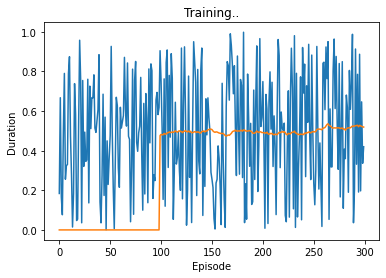

Episode 300 
 100 episode moving avg: 0.51921034


In [13]:
plot(np.random.rand(300),100)

Setting the Hyperparameters


You can choose to play with them a little to see how it changes the outcome of your training.

In [0]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

Defining the necessary variables to carry out training.

You will notice that we defined 2 networks, one with updating gradients and the other with no gradient updatation. The policy_net is used for carrying out training whereas the target_net is used to get the Q values of the next states.

We do not use the same network for doing the same because then the Q values won't converge to the optimal values as both Q(s,a) and Q(s',a') will keep improving with the same network. As a result we have a target_net whose weights are updated in a few iterations after training the policy_net.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start,eps_end,eps_decay)
agent = Agent(strategy,em.num_actions_available(),device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(),em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(),em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(),lr=lr)

This is the most tricky part of this code.

Extract tensors is a function which extracts the individual entities of the named tuple Experience and stores them in a list form and returns a tuple of 4 (state,action,reward,next_state)


QValues has 2 statict methods as a result you don't have to explicitly create an instance of this class.
This is the class that we used to calculate the q-values for the current states using the policy_net, and the next states using the target_net.
The first function just returns the predicted q-values from the policy_net for the specific state-action pairs that were passed in.


The second function accepts a target_net and next_states. Recall that for each next state, we want to obtain the maximum q-value predicted by the target_net among all possible next actions.

To do that, we first look in our next_states tensor and find the locations of all the final states. If an episode is ended by a given action, then we’re calling the next_state that occurs after that action was taken the final state.

As all final states are represented using a black screen, we equate it to 0 to check for final states. After getting the location of the final states, we get the location of the non-final states.

We did this so that we we do not compute the Q values of the final states as they will always be 0. Now we define the batch_size and make torch array of zeros and store it in variable vlaues.
Later we calculated the Qvalues of the non-final states and stored it in the values variable.

So now, we have final states with Q values 0 and non-final states with Qvalues estimated by target_net.



In [0]:
def extract_tensors(experiences):

  batch = Experience(*zip(*experiences))

  t1 = torch.cat(batch.state)
  t2 = torch.cat(batch.action)
  t3 = torch.cat(batch.reward)
  t4 = torch.cat(batch.next_state)

  return (t1,t2,t3,t4)

class QValues():
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  @staticmethod
  def get_current(policy_net,states,actions):
    return policy_net(states).gather(dim=1,index=actions.unsqueeze(-1))

  @staticmethod
  def get_next(target_net, next_states):
    final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
    non_final_state_locations = (final_state_locations == False)
    non_final_states = next_states[non_final_state_locations]
    batch_size = next_states.shape[0]
    values = torch.zeros(batch_size).to(QValues.device)
    values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
    return values

Here we train the network to get the following results.

Note that we are only training iff we can sample a batch from the Replay Memory. If not then we keep appending to the Replay Memory till we can obtain a batch of the desired size from it.

In [17]:
episode_durations = []

for episode in range(num_episodes):
  em.reset()
  state = em.get_state()

  for timestep in count():
    action = agent.select_action(state,policy_net)
    reward = em.take_action(action)
    next_state = em.get_state()
    memory.push(Experience(state,action,next_state,reward))
    state = next_state

    if memory.can_provide_sample(batch_size):
      experiences = memory.sample(batch_size)
      states,actions,rewards,next_states = extract_tensors(experiences)

      current_q_values = QValues.get_current(policy_net,states,actions)
      next_q_values = QValues.get_next(target_net,next_states)
      target_q_values = (next_q_values*gamma)+rewards

      loss = F.mse_loss(current_q_values,target_q_values.unsqueeze(1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if em.done:
      episode_durations.append(timestep)
      plot(episode_durations,100)
      break
  if episode%target_update==0:
    target_net.load_state_dict(policy_net.state_dict())
  # em.reset()

em.close()
show_video()